In [26]:
# Importing the libraries
import numpy as np
import pandas as pd

In [27]:
# get datasets

nhs = pd.read_csv('nhsDataFinal.csv')

bib = pd.read_csv('BiBFullDataset.csv')

# create new dataframe with non-GDM women only
bib_gdm = bib[bib['gdm'] == 'Yes']
bib_nonGdm = bib[bib['gdm'] == 'No']

In [28]:
def constructDataFrame(nhsFeature, bibFeature):
    import pandas as pd
    # load data file
    df = pd.concat([nhs[nhsFeature], bib_gdm[bibFeature], bib_nonGdm[bibFeature]], axis=1, keys=['nhs', 'bib-GDM', 'bib-nonGDM'])
    # reshape the d dataframe suitable for statsmodels package 
    df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['nhs', 'bib-GDM', 'bib-nonGDM'])

    # replace column names
    df_melt.columns = ['index', 'datasets', 'value']
    
    df_melt = df_melt.dropna()
    return df, df_melt

# ANOVA Test

In [49]:
def ANOVA(df, df_melt):
    import scipy.stats as stats
    # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
    fvalue, pvalue = stats.f_oneway(df['nhs'].dropna(), df['bib-GDM'].dropna(), df['bib-nonGDM'].dropna())
    print(fvalue, pvalue)

    # get ANOVA table as R like output
    import statsmodels.api as sm
    from statsmodels.formula.api import ols

    # Ordinary Least Squares (OLS) model
    model = ols('value ~ C(datasets)', data=df_melt).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_table
    
    # ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
    from bioinfokit.analys import stat
    res = stat()
    res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(datasets)')
    res.anova_summary
    return res

# Post Hoc Comparison
Tukey’s HSD test accounts for multiple comparisons and corrects for family-wise error rate (FWER) (inflated type I error)


In [47]:
def tukeyHSD(df_melt):
    # we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
    # check documentation here https://github.com/reneshbedre/bioinfokit
    from bioinfokit.analys import stat
    # perform multiple pairwise comparison (Tukey's HSD)
    # unequal sample size data, tukey_hsd uses Tukey-Kramer test
    res = stat()
    res.tukey_hsd(df=df_melt, res_var='value', xfac_var='datasets', anova_model='value ~ C(datasets)')
    res.tukey_summary

# ANOVA Assumptions
- Residuals (experimental error) are approximately normally distributed (Shapiro-Wilks test or histogram)
- homoscedasticity or Homogeneity of variances (variances are equal between treatment groups) (Levene’s, Bartlett’s, or Brown-Forsythe test)
- Observations are sampled independently from each other (no relation in observations between the groups and within the groups) i.e., each subject should have only one response
- The dependent variable should be continuous. If the dependent variable is ordinal or rank (e.g. Likert item data), it is more likely to violate the assumptions of normality and homogeneity of variances. 

If these assumptions are violated, you should consider the non-parametric tests (e.g. Mann-Whitney U test, Kruskal-Wallis test).

# Test ANOVA Assumptions

## 1. Normal Distribution

Visually - Checking for normal distribution using visual approaches such as residual plots (e.g. QQ-plots) and histograms.

- QQ plot:
If the standardized residuals lie around the 45-degree line, it suggests that the residuals are approximately normally distributed

In [52]:
def QQPlot(res):
    # QQ-plot
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    # res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
    sm.qqplot(res.anova_std_residuals, line='45')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residuals")
    plt.show()

- Histogram:
In the histogram, if the distribution looks approximately normal, this suggests that residuals are approximately normally distributed

In [57]:
def histogram(res):
    import matplotlib.pyplot as plt
    # histogram
    plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
    plt.xlabel("Residuals")
    plt.ylabel('Frequency')
    plt.show()

Using statistical test

Shapiro-Wilk test can be used to check the normal distribution of residuals. Null hypothesis: data is drawn from normal distribution.

In [40]:
# Shapiro-Wilk test can be used to check the normal distribution of residuals. 
# Null hypothesis: data is drawn from normal distribution.
# If p value is non significant, we fail to reject null hypothesis and conclude that data is drawn from normal distribution.

def shapiro():
    import scipy.stats as stats
    w, pvalue = stats.shapiro(model.resid)
    print(w, pvalue)

## 2. Homogeneity of variances 

If the data is drawn from normal distribution, use Bartlett’s test to check the Homogeneity of variances. Null hypothesis: samples from populations have equal variances.

In [59]:
# If the data is drawn from normal distribution, use Bartlett’s test to check the Homogeneity of variances. 
# Null hypothesis: samples from populations have equal variances.
# If p value is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

def barlett(df, df_melt):
    import scipy.stats as stats
    w, pvalue = stats.bartlett(df['nhs'], df['bib-GDM'], df['bib-nonGDM'])
    print(w, pvalue)

    # if you have a stacked table, you can use bioinfokit v1.0.3 or later for the bartlett's test
    from bioinfokit.analys import stat 
    res = stat()
    res.bartlett(df=df_melt, res_var='value', xfac_var='datasets')
    res.bartlett_summary

Levene’s test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

In [60]:
# Levene’s test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

def levene(df_melt):
    # if you have a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
    from bioinfokit.analys import stat 
    res = stat()
    res.levene(df=df_melt, res_var='value', xfac_var='datasets')
    res.levene_summary

In [61]:
def anovaPipeline(nhsFeature, bibFeature):
    # generate dataframe
    df, df_melt = constructDataFrame(nhsFeature, bibFeature)
    
    # Do anova test and then post hoc comparison if p is significant
    # anova test
    res = ANOVA(df, df_melt)
    
    # post hoc comparison
    tukeyHSD(df_melt)
    
    # check anova assumptions
    # normal distribution
    QQPlot(res)
    histogram(res)
    
    # homogenity
    barlett(df, df_melt)

## Maternal Age

200.51561053468689 3.1418068228637043e-86


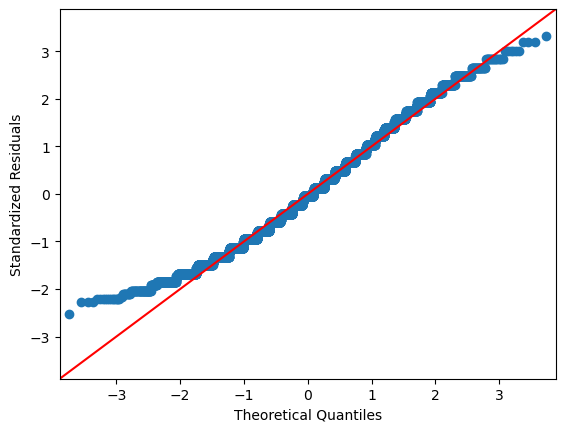

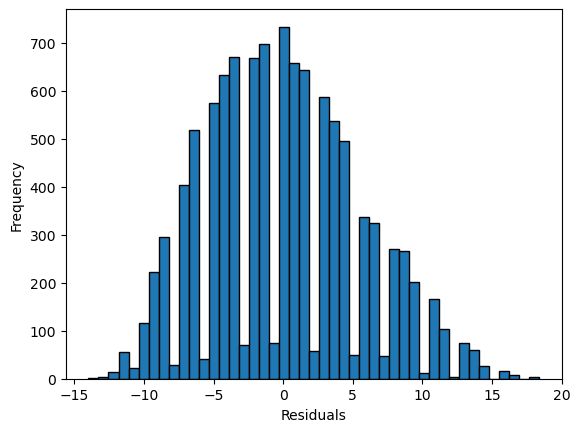

17.20248063230048 0.00018387758583252793


In [62]:
anovaPipeline("maternalAgeAtBirth", "maternalAge")